<a href="https://www.kaggle.com/code/monicamedhat12/csic-2010-web-application-attacks-classifier?scriptVersionId=159185014" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip uninstall -y apache-beam chex momepy pymc3 ydata-profiling
!pip install numpy==1.23.5


Found existing installation: apache-beam 2.46.0
Uninstalling apache-beam-2.46.0:
  Successfully uninstalled apache-beam-2.46.0
Found existing installation: chex 0.1.81
Uninstalling chex-0.1.81:
  Successfully uninstalled chex-0.1.81
Found existing installation: momepy 0.6.0
Uninstalling momepy-0.6.0:
  Successfully uninstalled momepy-0.6.0
Found existing installation: pymc3 3.11.5
Uninstalling pymc3-3.11.5:
  Successfully uninstalled pymc3-3.11.5
Found existing installation: ydata-profiling 4.3.1
Uninstalling ydata-profiling-4.3.1:
  Successfully uninstalled ydata-profiling-4.3.1


# CSIC-2010 DATASET
 The dataset contains the generated traffic targeted to an e-commerce web
application. It is an automatically generated dataset that contains 36,000 normal
requests and more than 25,000 anomalous requests (i.e., web attacks).

In [2]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
import re
import math
import eli5

#dataset pre-processing realated imports
import sklearn
from eli5.sklearn import PermutationImportance
from urllib.parse import urlparse
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


#imports related to classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression 
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPClassifier

#DNN imports
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau

#Explainability imports
from sklearn.inspection import PartialDependenceDisplay




/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [3]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
print('Done!')

/kaggle/input/csic-2010-web-application-attacks/csic_database.csv
Done!


**READ CSV**

In [4]:
csic_filepath='/kaggle/input/csic-2010-web-application-attacks/csic_database.csv'
csic_data=pd.read_csv(csic_filepath)
print('Done!')

Done!


In [5]:
n_features=csic_data.shape[1]
n_samples =csic_data.shape[0]


print("Number of samples:", n_samples)
print("Number of features:", n_features)




Number of samples: 61065
Number of features: 17


In [6]:
# csic_data.head()

In [7]:
# csic_data.tail()

In [8]:
# csic_data.columns



# **Data Visualization**

In [9]:
# sns.set_style('darkgrid')
# sns.countplot(data=csic_data, x='Unnamed: 0')

Dropping samples with at least 1 NaN value will make to lose all the other Request Methods besides POST, this option is discarded since dropping data is not usually a good choice

In [10]:
# csic_data.head()

Visualizing URL format

In [11]:
feature_names=[ 'Unnamed: 0','Method', 'User-Agent', 'Pragma', 'Cache-Control',
       'Accept', 'Accept-encoding', 'Accept-charset', 'language', 'host',
       'cookie', 'content-type', 'connection', 'lenght', 'content','classification',
        'URL']

X=csic_data[feature_names]
print(X)

      Unnamed: 0 Method                                         User-Agent  \
0         Normal    GET  Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...   
1         Normal    GET  Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...   
2         Normal   POST  Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...   
3         Normal    GET  Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...   
4         Normal   POST  Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...   
...          ...    ...                                                ...   
61060  Anomalous    GET  Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...   
61061  Anomalous   POST  Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...   
61062  Anomalous    GET  Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...   
61063  Anomalous    GET  Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...   
61064  Anomalous    GET  Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...   

         Pragma Cache-Control  \
0      no-cache      no-cache 

# **Removing not discriminatory features**

**Enumerating unique values for each feature**

In [12]:
# Removing not discriminatory Features and making some adjustments on feature names
X = X.rename(columns={'Unnamed: 0': 'Class'})
X = X.rename(columns={'lenght': 'content_length'})


feature_names=[ 'Class','Method','host','cookie','Accept', 'content_length', 'content','classification','URL']

# Print the remaining data
X = X[feature_names]
print(X)

           Class Method            host  \
0         Normal    GET  localhost:8080   
1         Normal    GET  localhost:8080   
2         Normal   POST  localhost:8080   
3         Normal    GET  localhost:8080   
4         Normal   POST  localhost:8080   
...          ...    ...             ...   
61060  Anomalous    GET  localhost:8080   
61061  Anomalous   POST  localhost:8080   
61062  Anomalous    GET  localhost:8080   
61063  Anomalous    GET  localhost:8080   
61064  Anomalous    GET  localhost:8080   

                                            cookie  \
0      JSESSIONID=1F767F17239C9B670A39E9B10C3825F4   
1      JSESSIONID=81761ACA043B0E6014CA42A4BCD06AB5   
2      JSESSIONID=933185092E0B668B90676E0A2B0767AF   
3      JSESSIONID=8FA18BA82C5336D03D3A8AFA3E68CBB0   
4      JSESSIONID=7104E6C68A6BCF1423DAE990CE49FEE2   
...                                            ...   
61060  JSESSIONID=62216ADBBD9B91E17CA9AFEDCCC36275   
61061  JSESSIONID=2317F5C0B1B7FAD18EB425E98DB102A3 

In [13]:
y=X.Class
print(y)


0           Normal
1           Normal
2           Normal
3           Normal
4           Normal
           ...    
61060    Anomalous
61061    Anomalous
61062    Anomalous
61063    Anomalous
61064    Anomalous
Name: Class, Length: 61065, dtype: object


In [14]:
size=X.shape[1]
# Get list of categorical variables
s = (X.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables:")
print(object_cols)

Categorical variables:
['Class', 'Method', 'host', 'cookie', 'Accept', 'content_length', 'content', 'URL']


Load Models

# **Pre-processing on the feature: Content Length**

In [15]:
print(X.content_length)

0                        NaN
1                        NaN
2         Content-Length: 68
3                        NaN
4         Content-Length: 63
                ...         
61060                    NaN
61061    Content-Length: 255
61062                    NaN
61063                    NaN
61064                    NaN
Name: content_length, Length: 61065, dtype: object


Operations on the 'content_lenght' feature

In [16]:
#replace NaN values with 0
#removing the 'Content-Lenght' string and keeping only the numerical value

X['content_length'] = X['content_length'].astype(str)
X['content_length'] = X['content_length'].str.extract(r'(\d+)')
X['content_length'] = pd.to_numeric(X['content_length'], errors='coerce').fillna(0)
print(X.content_length)


0          0.0
1          0.0
2         68.0
3          0.0
4         63.0
         ...  
61060      0.0
61061    255.0
61062      0.0
61063      0.0
61064      0.0
Name: content_length, Length: 61065, dtype: float64


GET methods have the content_length set to 0 since they where all NaN (this method does not have to provide content)

In [17]:
filtered_length = X.loc[X['Method'] == 'GET', 'content_length']
print(filtered_length)


0        0.0
1        0.0
3        0.0
5        0.0
7        0.0
        ... 
61058    0.0
61060    0.0
61062    0.0
61063    0.0
61064    0.0
Name: content_length, Length: 43088, dtype: float64


# URL PRE-PROCESSING

In [18]:
url_counts = X['URL'].value_counts()
most_common_urls = url_counts.head(10)  # Extract the top 10 most common strings

print("Most common URLs:")
for i, (url, count) in enumerate(most_common_urls.items(), 1):
    print(f"{i}. URL: {url} - Count: {count}")


Most common URLs:
1. URL: http://localhost:8080/tienda1/publico/anadir.jsp HTTP/1.1 - Count: 2441
2. URL: http://localhost:8080/tienda1/publico/autenticar.jsp HTTP/1.1 - Count: 2422
3. URL: http://localhost:8080/tienda1/publico/registro.jsp HTTP/1.1 - Count: 2417
4. URL: http://localhost:8080/tienda1/miembros/editar.jsp HTTP/1.1 - Count: 2412
5. URL: http://localhost:8080/tienda1/publico/pagar.jsp HTTP/1.1 - Count: 2379
6. URL: http://localhost:8080/tienda1/publico/caracteristicas.jsp HTTP/1.1 - Count: 2003
7. URL: http://localhost:8080/tienda1/publico/vaciar.jsp HTTP/1.1 - Count: 1965
8. URL: http://localhost:8080/tienda1/publico/entrar.jsp HTTP/1.1 - Count: 1938
9. URL: http://localhost:8080/tienda1/index.jsp HTTP/1.1 - Count: 1000
10. URL: http://localhost:8080/tienda1/miembros/salir.jsp HTTP/1.1 - Count: 1000


**Utils for URL/Content pre-processing**

In [19]:
def count_dot(url):
    count_dot = url.count('.')
    return count_dot


def no_of_dir(url):
    urldir = urlparse(url).path
    return urldir.count('/')

def no_of_embed(url):
    urldir = urlparse(url).path
    return urldir.count('//')

def shortening_service(url):
    match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'tr\.im|link\.zip\.net',
                      url)
    if match:
        return 1
    else:
        return 0


def count_http(url):
    return url.count('http')

def count_per(url):
    return url.count('%')

def count_ques(url):
    return url.count('?')

def count_hyphen(url):
    return url.count('-')


def count_equal(url):
    return url.count('=')


def url_length(url):
    return len(str(url))

#Hostname Length

def hostname_length(url):
    return len(urlparse(url).netloc)


import re

def suspicious_words(url):
    score_map = {
        'error': 30,
        'errorMsg': 30,
        'id': 10,
        'errorID': 30,
        'SELECT': 50,
        'FROM': 50,
        'WHERE': 50,
        'DELETE': 50,
        'USERS': 50,
        'DROP': 50,
        'CREATE': 50,
        'INJECTED': 50,
        'TABLE': 50,
        'alert': 30,
        'javascript': 20,
        'cookie': 25,
        '--': 30,
        '.exe': 30,
        '.php': 20,
        '.js': 10,
        'admin': 10,
        'administrator': 10,
        '\'': 30,
        'password': 15,
        'login': 15,
        'incorrect': 20,
        'pwd': 15,
        'tamper': 25,
        'vaciar': 20,
        'carrito': 25,
        'wait': 30,
        'delay': 35,
        'set': 20,
        'steal': 35,
        'hacker': 35,
        'proxy': 35,
        'location': 30,
        'document.cookie': 40,
        'document': 20,
        'set-cookie': 40,
        'create': 40,
        'cmd': 40,
        'dir': 30,
        'shell': 40,
        'reverse': 30,
        'bin': 20,
        'cookiesteal': 40,
        'LIKE': 30,
        'UNION': 35,
        'include': 30,
        'file': 20,
        'tmp': 25,
        'ssh': 40,
        'exec': 30,
        'cat': 25,
        'etc': 30,
        'fetch': 25,
        'eval': 30,
        'wait': 30,
        'malware': 45,
        'ransomware': 45,
        'phishing': 45,
        'exploit': 45,
        'virus': 45,
        'trojan': 45,
        'backdoor': 45,
        'spyware': 45,
        'rootkit': 45,
        'credential': 30,
        'inject': 30,
        'script': 25,
        'iframe': 25,
        'src=': 25,
        'onerror': 30,
        'prompt': 20,
        'confirm': 20,
        'eval': 25,
        'expression': 30,
        'function\(': 20,
        'xmlhttprequest': 30,
        'xhr': 20,
        'window.': 20,
        'document.': 20,
        'cookie': 25,
        'click': 15,
        'mouseover': 15,
        'onload': 20,
        'onunload': 20,
    }

    matches = re.findall(r'(?i)' + '|'.join(score_map.keys()), url)

    total_score = sum(score_map.get(match.lower(), 0) for match in matches)
    return total_score


def digit_count(url):
    digits = 0
    for i in url:
        if i.isnumeric():
            digits = digits + 1
    return digits

def letter_count(url):
    letters = 0
    for i in url:
        if i.isalpha():
            letters += 1
    return letters

def count_special_characters(url):
    special_characters = re.sub(r'[a-zA-Z0-9\s]', '', url)
    count = len(special_characters)
    return count


# Number of Parameters in URL
def number_of_parameters(url):
    params = urlparse(url).query
    return 0 if params == '' else len(params.split('&'))

# Number of Fragments in URL
def number_of_fragments(url):
    frags = urlparse(url).fragment
    return len(frags.split('#')) - 1 if frags == '' else 0

# URL is Encoded
def is_encoded(url):
    return int('%' in url.lower())


def unusual_character_ratio(url):
    total_characters = len(url)
    unusual_characters = re.sub(r'[a-zA-Z0-9\s\-._]', '', url)
    unusual_count = len(unusual_characters)
    ratio = unusual_count / total_characters if total_characters > 0 else 0
    return ratio



In [20]:
X['count_dot_url'] = X['URL'].apply(count_dot)
X['count_dir_url'] = X['URL'].apply(no_of_dir)
X['count_embed_domain_url'] = X['URL'].apply(no_of_embed)
X['short_url'] = X['URL'].apply(shortening_service)
X['count-http'] = X['URL'].apply(count_http)
X['count%_url'] = X['URL'].apply(count_per)
X['count?_url'] = X['URL'].apply(count_ques)
X['count-_url'] = X['URL'].apply(count_hyphen)
X['count=_url'] = X['URL'].apply(count_equal)
X['hostname_length_url'] = X['URL'].apply(hostname_length)
X['sus_url'] = X['URL'].apply(suspicious_words)
X['count-digits_url'] = X['URL'].apply(digit_count)
X['count-letters_url'] = X['URL'].apply(letter_count)
X['url_length'] = X['URL'].apply(url_length)
X['number_of_parameters_url'] = X['URL'].apply(number_of_parameters)
X['number_of_fragments_url'] = X['URL'].apply(number_of_fragments)
X['is_encoded_url'] = X['URL'].apply(is_encoded)
X['special_count_url'] = X['URL'].apply(count_special_characters)
X['unusual_character_ratio_url'] = X['URL'].apply(unusual_character_ratio)



In [21]:
# Select the features and class variable for plotting
new_features = ['count_dot_url', 'count_dir_url', 'count_embed_domain_url', 'count-http',
                'count%_url', 'count?_url', 'count-_url', 'count=_url', 'url_length', 'hostname_length_url',
                'sus_url', 'count-digits_url', 'count-letters_url', 'number_of_parameters_url',
                'number_of_fragments_url', 'is_encoded_url','special_count_url','unusual_character_ratio_url']

# Create a DataFrame with the selected features
set = X[new_features]

for new_feature in X.columns:
    if new_feature in X.columns:
        unique_count = X[new_feature].nunique()
        print(f"Number of unique values for {new_feature}: {unique_count}")
    else:
        print(f"Column '{new_feature}' does not exist in the DataFrame.")



Number of unique values for Class: 2
Number of unique values for Method: 3
Number of unique values for host: 2
Number of unique values for cookie: 61065
Number of unique values for Accept: 1
Number of unique values for content_length: 383
Number of unique values for content: 12091
Number of unique values for classification: 2
Number of unique values for URL: 13498
Number of unique values for count_dot_url: 9
Number of unique values for count_dir_url: 7
Number of unique values for count_embed_domain_url: 2
Number of unique values for short_url: 2
Number of unique values for count-http: 2
Number of unique values for count%_url: 34
Number of unique values for count?_url: 2
Number of unique values for count-_url: 8
Number of unique values for count=_url: 5
Number of unique values for hostname_length_url: 5
Number of unique values for sus_url: 61
Number of unique values for count-digits_url: 112
Number of unique values for count-letters_url: 259
Number of unique values for url_length: 417
N

# Removing Cookies as feature
 **cookies are unique for each sample, this feature cannot be used as discriminant**

In [22]:
unique_count = X['cookie'].nunique()
print(f"Count of unique values in 'cookie': {unique_count}")


Count of unique values in 'cookie': 61065


# Encoding categorical features

In [23]:
X['Accept'] = X['Accept'].astype(str)
X['Accept'] = X['Accept'].str.extract(r'(\d+)')
X['Accept'] = pd.to_numeric(X['Accept'], errors='coerce').fillna(1)

In [24]:
lb_make = LabelEncoder()
X["Method_enc"] = lb_make.fit_transform(X["Method"])
X["host_enc"] =lb_make.fit_transform(X["host"])
X["Accept_enc"] =lb_make.fit_transform(X["Accept"])


In [25]:
unique_count_met = X["Method_enc"].nunique()
unique_count_host = X["host_enc"].nunique()
unique_count_acc = X["Accept_enc"].nunique()


print(f"Number of unique values for 'Method_enc': {unique_count_met}")
print(f"Number of unique values for 'host_enc': {unique_count_host}")
print(f"Number of unique values for 'Accept_enc': {unique_count_acc}")





Number of unique values for 'Method_enc': 3
Number of unique values for 'host_enc': 2
Number of unique values for 'Accept_enc': 2


In [26]:
X.head()



,Class,Method,host,cookie,Accept,content_length,content,classification,URL,count_dot_url,...,count-letters_url,url_length,number_of_parameters_url,number_of_fragments_url,is_encoded_url,special_count_url,unusual_character_ratio_url,Method_enc,host_enc,Accept_enc
0,Normal,GET,localhost:8080,JSESSIONID=1F767F17239C9B670A39E9B10C3825F4,0.0,0.0,NaN,0,http://localhost:8080/tienda1/index.jsp HTTP/1.1,2,...,31,48,0,0,0,9,0.145833,0,0,0
1,Normal,GET,localhost:8080,JSESSIONID=81761ACA043B0E6014CA42A4BCD06AB5,0.0,0.0,NaN,0,http://localhost:8080/tienda1/publico/anadir.j...,2,...,86,126,5,0,1,24,0.174603,0,0,0
2,Normal,POST,localhost:8080,JSESSIONID=933185092E0B668B90676E0A2B0767AF,0.0,68.0,id=3&nombre=Vino+Rioja&precio=100&cantidad=55&...,0,http://localhost:8080/tienda1/publico/anadir.j...,2,...,39,57,0,0,0,10,0.140351,1,0,0
3,Normal,GET,localhost:8080,JSESSIONID=8FA18BA82C5336D03D3A8AFA3E68CBB0,0.0,0.0,NaN,0,http://localhost:8080/tienda1/publico/autentic...,2,...,92,125,5,0,1,21,0.152000,0,0,0
4,Normal,POST,localhost:8080,JSESSIONID=7104E6C68A6BCF1423DAE990CE49FEE2,0.0,63.0,modo=entrar&login=choong&pwd=d1se3ci%F3n&remem...,0,http://localhost:8080/tienda1/publico/autentic...,2,...,43,61,0,0,0,10,0.131148,1,0,0


In [27]:
X.tail()

,Class,Method,host,cookie,Accept,content_length,content,classification,URL,count_dot_url,...,count-letters_url,url_length,number_of_parameters_url,number_of_fragments_url,is_encoded_url,special_count_url,unusual_character_ratio_url,Method_enc,host_enc,Accept_enc
61060,Anomalous,GET,localhost:8080,JSESSIONID=62216ADBBD9B91E17CA9AFEDCCC36275,0.0,0.0,NaN,1,http://localhost:8080/tienda1/miembros/editar....,3,...,218,314,13,0,1,48,0.143312,0,0,0
61061,Anomalous,POST,localhost:8080,JSESSIONID=2317F5C0B1B7FAD18EB425E98DB102A3,0.0,255.0,modo=registro&login=beaumont&password=quEratIt...,1,http://localhost:8080/tienda1/miembros/editar....,2,...,40,58,0,0,0,10,0.137931,1,0,0
61062,Anomalous,GET,localhost:8080,JSESSIONID=7F0BA54A88B849EF752006D388E15CDD,0.0,0.0,NaN,1,http://localhost:8080/tienda1/miembros/editar....,3,...,43,62,0,0,0,11,0.129032,0,0,0
61063,Anomalous,GET,localhost:8080,JSESSIONID=FB018FFB06011CFABD60D8E8AD58CA21,0.0,0.0,NaN,1,http://localhost:8080/tienda1/imagenes/3.gif/ ...,2,...,34,54,0,0,0,11,0.166667,0,0,0
61064,Anomalous,GET,localhost:8080,JSESSIONID=3CC12010CDA952F123240EBAD79B55CC,0.0,0.0,NaN,1,http://localhost:8080/tienda1/imagenes/nuestra...,3,...,50,69,0,0,0,11,0.115942,0,0,0


In [28]:
def apply_to_content(content,function):
    if pd.isna(content):
        return 0
    elif isinstance(content, str):
        return function(content)

#"""
#                'count_dot_content','count_dir_content','count_embed_domain_content','count%_content','count?_content',
 #               'count-_content','count=_content','hostname_length_content','sus_content','count_digits_content',
  #              'count_letters_content','content_length','number_of_parameters_content','number_of_fragments_content',
   #             'is_encoded_content','special_count_content','unusual_character_ratio_content'
    #            ]"""

X['count_dot_content'] = X['content'].apply(apply_to_content, function=count_dot)
X['count_dir_content'] = X['content'].apply(apply_to_content, function=no_of_dir)
X['count_embed_domain_content'] = X['content'].apply(apply_to_content, function=no_of_embed)
X['count%_content'] = X['content'].apply(apply_to_content, function=count_per)
X['count?_content'] = X['content'].apply(apply_to_content, function=count_ques)
X['count-_content'] = X['content'].apply(apply_to_content, function=count_hyphen)
X['count=_content'] = X['content'].apply(apply_to_content, function=count_equal)
X['content_length'] = X['content'].apply(apply_to_content, function=url_length)
X['sus_content'] = X['content'].apply(apply_to_content, function=suspicious_words)
X['count_digits_content'] = X['content'].apply(apply_to_content, function=digit_count)
X['count_letters_content'] = X['content'].apply(apply_to_content, function=letter_count)
X['special_count_content'] = X['content'].apply(apply_to_content, function=count_special_characters)
X['is_encoded_content'] = X['content'].apply(apply_to_content, function=is_encoded)
#X['unusual_character_ratio_content'] = X['content'].apply(apply_to_content, function=unusual_character_ratio)






In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select the features and class variable for plotting
new_content_features = ['count_dot_content', 'count_dir_content', 'count_embed_domain_content', 'count%_content', 'count?_content',
                        'count-_content', 'count=_content', 'sus_content', 'count_digits_content',
                        'count_letters_content', 'content_length', 'is_encoded_content', 'special_count_content']

# Create a DataFrame with the selected features
selected_features_df = X[new_content_features]

for feature_name in selected_features_df.columns:
    if feature_name in X.columns:
        unique_count = selected_features_df[feature_name].nunique()
        print(f"Number of unique values for {feature_name}: {unique_count}")
    else:
        print(f"Column '{feature_name}' does not exist in the DataFrame.")


Number of unique values for count_dot_content: 8
Number of unique values for count_dir_content: 1
Number of unique values for count_embed_domain_content: 1
Number of unique values for count%_content: 34
Number of unique values for count?_content: 1
Number of unique values for count-_content: 8
Number of unique values for count=_content: 5
Number of unique values for sus_content: 57
Number of unique values for count_digits_content: 111
Number of unique values for count_letters_content: 230
Number of unique values for content_length: 383
Number of unique values for is_encoded_content: 2
Number of unique values for special_count_content: 87


In [30]:
X.columns

Index(['Class', 'Method', 'host', 'cookie', 'Accept', 'content_length',
       'content', 'classification', 'URL', 'count_dot_url', 'count_dir_url',
       'count_embed_domain_url', 'short_url', 'count-http', 'count%_url',
       'count?_url', 'count-_url', 'count=_url', 'hostname_length_url',
       'sus_url', 'count-digits_url', 'count-letters_url', 'url_length',
       'number_of_parameters_url', 'number_of_fragments_url', 'is_encoded_url',
       'special_count_url', 'unusual_character_ratio_url', 'Method_enc',
       'host_enc', 'Accept_enc', 'count_dot_content', 'count_dir_content',
       'count_embed_domain_content', 'count%_content', 'count?_content',
       'count-_content', 'count=_content', 'sus_content',
       'count_digits_content', 'count_letters_content',
       'special_count_content', 'is_encoded_content'],
      dtype='object')

# **Building the final dataset to use for the classification**

In [31]:
X.columns

Index(['Class', 'Method', 'host', 'cookie', 'Accept', 'content_length',
       'content', 'classification', 'URL', 'count_dot_url', 'count_dir_url',
       'count_embed_domain_url', 'short_url', 'count-http', 'count%_url',
       'count?_url', 'count-_url', 'count=_url', 'hostname_length_url',
       'sus_url', 'count-digits_url', 'count-letters_url', 'url_length',
       'number_of_parameters_url', 'number_of_fragments_url', 'is_encoded_url',
       'special_count_url', 'unusual_character_ratio_url', 'Method_enc',
       'host_enc', 'Accept_enc', 'count_dot_content', 'count_dir_content',
       'count_embed_domain_content', 'count%_content', 'count?_content',
       'count-_content', 'count=_content', 'sus_content',
       'count_digits_content', 'count_letters_content',
       'special_count_content', 'is_encoded_content'],
      dtype='object')

In [32]:
labels=['count_dot_url', 'count_dir_url', 'count_embed_domain_url', 'count-http',
                'count%_url', 'count?_url', 'count-_url', 'count=_url', 'url_length', 'hostname_length_url',
                'sus_url', 'count-digits_url', 'count-letters_url', 'number_of_parameters_url',
                'is_encoded_url','special_count_url','unusual_character_ratio_url',
                 #method
                'Method_enc',
                #content
                'count_dot_content','count%_content',
                 'count-_content','count=_content','sus_content','count_digits_content',
                  'count_letters_content','content_length',
               'is_encoded_content','special_count_content']
print(X[labels])


       count_dot_url  count_dir_url  count_embed_domain_url  count-http  \
0                  2              3                       0           1   
1                  2              3                       0           1   
2                  2              4                       0           1   
3                  2              3                       0           1   
4                  2              4                       0           1   
...              ...            ...                     ...         ...   
61060              3              3                       0           1   
61061              2              4                       0           1   
61062              3              4                       0           1   
61063              2              5                       0           1   
61064              3              4                       0           1   

       count%_url  count?_url  count-_url  count=_url  url_length  \
0               0           0 

In [33]:
y=X['classification']
print(y)

0        0
1        0
2        0
3        0
4        0
        ..
61060    1
61061    1
61062    1
61063    1
61064    1
Name: classification, Length: 61065, dtype: int64


In [34]:
print('computing...)')
#split dataset in test and train 
x_tr, x_ts, y_tr, y_ts = train_test_split(X[labels], y, test_size=0.3, random_state=0)


print('Done!')


computing...)
Done!


In [35]:
x_tr.head(5)



,count_dot_url,count_dir_url,count_embed_domain_url,count-http,count%_url,count?_url,count-_url,count=_url,url_length,hostname_length_url,...,count_dot_content,count%_content,count-_content,count=_content,sus_content,count_digits_content,count_letters_content,content_length,is_encoded_content,special_count_content
23480,2,3,0,1,0,1,0,1,91,14,...,0,0,0,0,0,0,0,0,0,0
45171,2,3,0,1,14,1,2,1,125,14,...,0,0,0,0,0,0,0,0,0,0
9460,2,4,0,1,0,0,0,0,57,14,...,0,0,0,0,0,0,0,0,0,0
9905,2,3,0,1,0,1,0,1,71,14,...,0,0,0,0,0,0,0,0,0,0
8937,2,4,0,1,0,0,0,0,57,14,...,0,0,0,1,50,0,31,33,0,2


In [36]:
x_tr.tail(5)

,count_dot_url,count_dir_url,count_embed_domain_url,count-http,count%_url,count?_url,count-_url,count=_url,url_length,hostname_length_url,...,count_dot_content,count%_content,count-_content,count=_content,sus_content,count_digits_content,count_letters_content,content_length,is_encoded_content,special_count_content
45891,2,3,0,1,0,1,0,1,76,14,...,0,0,0,0,0,0,0,0,0,0
52416,2,4,0,1,0,0,0,0,57,14,...,0,0,0,1,50,0,32,34,0,2
42613,2,3,0,1,0,1,0,3,95,14,...,0,0,0,0,0,0,0,0,0,0
43567,3,3,0,1,4,1,0,13,324,14,...,0,0,0,0,0,0,0,0,0,0
2732,2,4,0,1,0,0,0,0,53,14,...,0,0,0,0,0,0,0,0,0,0


# Classifiers

**RANDOM FOREST**

In [37]:
random_forest_model = RandomForestClassifier(random_state=1000)
print('Computing....')
# Fit the model
random_forest_model.fit(x_tr,y_tr)
print('Done!')

Computing....
Done!


In [38]:
RT_predictions= random_forest_model.predict(x_ts)
print('MAE', mean_absolute_error(y_ts, RT_predictions))
print("Accuracy", accuracy_score(y_ts, RT_predictions))
print("Precision", precision_score(y_ts, RT_predictions, average='weighted', labels=np.unique(RT_predictions)))
print("Recall", recall_score(y_ts, RT_predictions, average='weighted', labels=np.unique(RT_predictions)))
print("F1", f1_score(y_ts, RT_predictions, average='weighted', labels=np.unique(RT_predictions)))
print("ROC AUC", roc_auc_score(y_ts, RT_predictions, average='weighted', labels=np.unique(RT_predictions)))
error_rt = (RT_predictions != y_ts).mean()
print("Test error: {:.1%}".format(error_rt))


MAE 0.07374454148471615
Accuracy 0.9262554585152838
Precision 0.9261917594808624
Recall 0.9262554585152838
F1 0.9262150260558555
ROC AUC 0.9234171756395833
Test error: 7.4%


In [39]:
print(y_tr.unique())
print(y_tr.name)

[0 1]
classification


In [40]:
x_ts = x_ts.reset_index(drop=True)
y_ts = y_ts.reset_index(drop=True)

for k in range(np.unique(y_ts).size):
    print('mean of class ' + str(k) + ':\n', x_ts[y_ts == k].mean(axis=0))


mean of class 0:
 count_dot_url                   2.072631
count_dir_url                   3.831210
count_embed_domain_url          0.000000
count-http                      1.000000
count%_url                      0.273319
count?_url                      0.221706
count-_url                      0.024644
count=_url                      1.173812
url_length                     79.160606
hostname_length_url            14.000000
sus_url                        21.204315
count-digits_url                9.812703
count-letters_url              55.086766
number_of_parameters_url        1.173812
is_encoded_url                  0.090951
special_count_url              13.261136
unusual_character_ratio_url     0.140332
Method_enc                      0.226448
count_dot_content               0.073189
count%_content                  0.272110
count-_content                  0.024644
count=_content                  1.189529
sus_content                    10.676090
count_digits_content            2.77104

In [41]:
print(classification_report(y_ts, RT_predictions, target_names = ['Normal (class 0)','Anomalous (class 1)']))

                     precision    recall  f1-score   support

   Normal (class 0)       0.93      0.94      0.94     10753
Anomalous (class 1)       0.91      0.91      0.91      7567

           accuracy                           0.93     18320
          macro avg       0.92      0.92      0.92     18320
       weighted avg       0.93      0.93      0.93     18320



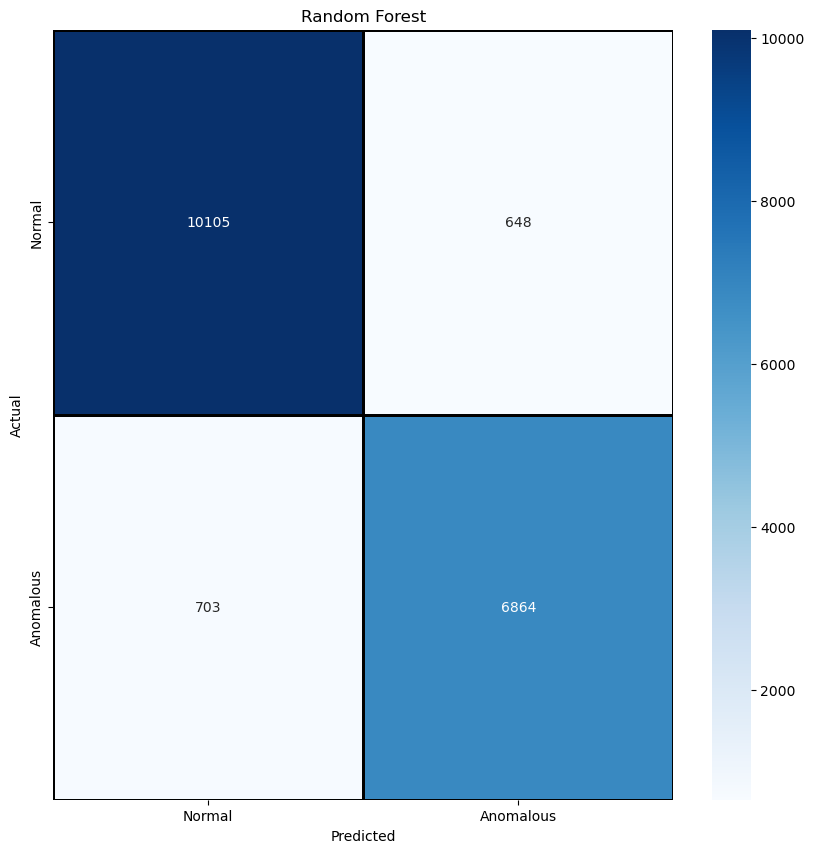

In [42]:


label = ['Normal', 'Anomalous']
cm = confusion_matrix(y_ts, RT_predictions)
cm = pd.DataFrame(cm, index=['0', '1'], columns=['0', '1'])

plt.figure(figsize=(10, 10))
sns.heatmap(cm, cmap="Blues", linecolor='black', linewidth=1, annot=True, fmt='', xticklabels=label, yticklabels=label)
plt.title("Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


**K-NEAREST NEIGHBOR**


In [43]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

#knn_model = KNeighborsClassifier()

#param_grid = {'n_neighbors': [3, 5, 7, 9,10,11, 13]}

#grid_search = GridSearchCV(knn_model, param_grid, cv=5)
#grid_search.fit(x_tr, y_tr)

#best_n_neighbors = grid_search.best_params_['n_neighbors']
#print("Best n_neighbors:", best_n_neighbors)

#final_model = KNeighborsClassifier(n_neighbors=best_n_neighbors)
#final_model.fit(x_tr, y_tr)

#knn_predictions = final_model.predict(x_ts)

Best n_neighbors: 9


In [44]:
final_model = KNeighborsClassifier(n_neighbors=9)
final_model.fit(x_tr, y_tr)
knn_predictions = final_model.predict(x_ts)

In [45]:
print('MAE', mean_absolute_error(y_ts, knn_predictions))
print("Accuracy", accuracy_score(y_ts, knn_predictions))
print("Precision", precision_score(y_ts, knn_predictions, average='weighted', labels=np.unique(knn_predictions)))
print("Recall", recall_score(y_ts, knn_predictions, average='weighted', labels=np.unique(knn_predictions)))
print("F1", f1_score(y_ts, knn_predictions, average='weighted', labels=np.unique(knn_predictions)))
print("ROC AUC", roc_auc_score(y_ts, knn_predictions, average='weighted', labels=np.unique(knn_predictions)))
error_knn = (knn_predictions != y_ts).mean()
print("Test error: {:.1%}".format(error_knn))

MAE 0.08471615720524017
Accuracy 0.9152838427947598
Precision 0.915150466570833
Recall 0.9152838427947598
F1 0.9151604867156559
ROC AUC 0.911251753162618
Test error: 8.5%


<Axes: title={'center': 'KN Neighbors'}>

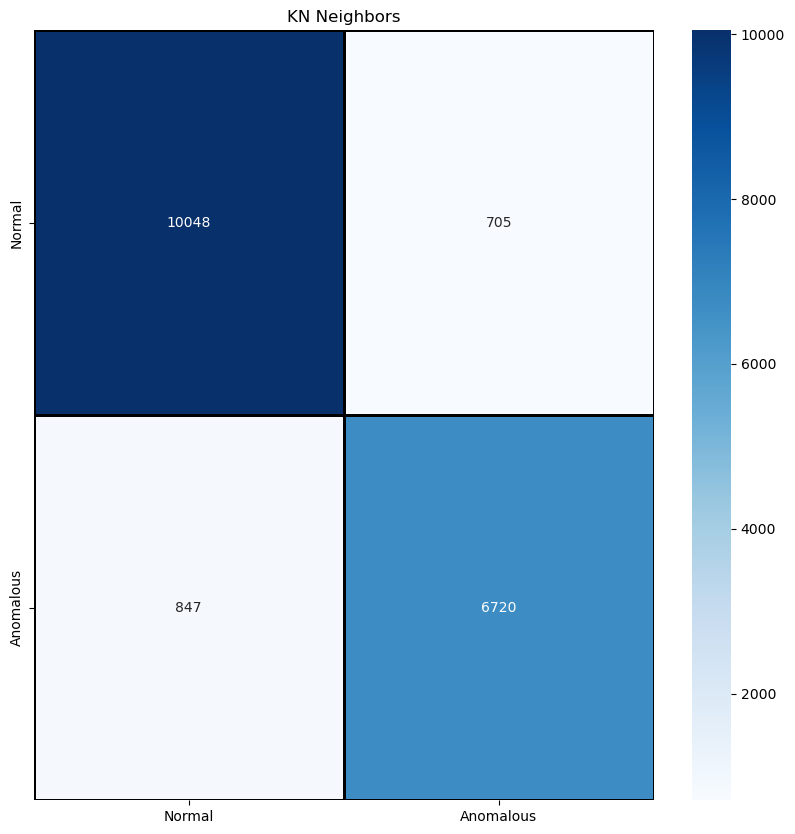

In [46]:
cm = confusion_matrix(y_ts,knn_predictions)
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
plt.figure(figsize = (10,10))
plt.title("KN Neighbors")
plt.xlabel("Predicted")
plt.ylabel("Actual")
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = label,yticklabels = label)


**DECISION TREE**

In [47]:
DT_model = DecisionTreeClassifier(random_state=2)
print('Computing....')
DT_model.fit(x_tr,y_tr)
print('Done!')

Computing....
Done!


In [48]:
DT_predictions= DT_model.predict(x_ts)
print('MAE', mean_absolute_error(y_ts, DT_predictions))
print("Accuracy", accuracy_score(y_ts, DT_predictions))
print("Precision", precision_score(y_ts, DT_predictions, average='weighted', labels=np.unique(DT_predictions)))
print("Recall", recall_score(y_ts, DT_predictions, average='weighted', labels=np.unique(DT_predictions)))
print("F1", f1_score(y_ts, DT_predictions, average='weighted', labels=np.unique(DT_predictions)))
print("ROC AUC", roc_auc_score(y_ts, DT_predictions, average='weighted', labels=np.unique(DT_predictions)))
error_dt = (DT_predictions != y_ts).mean()
print("Test error: {:.1%}".format(error_dt))

MAE 0.08133187772925764
Accuracy 0.9186681222707423
Precision 0.9185504062924272
Recall 0.9186681222707423
F1 0.918507216986483
ROC AUC 0.9142717136873706
Test error: 8.1%


<Axes: title={'center': 'Decision Tree'}>

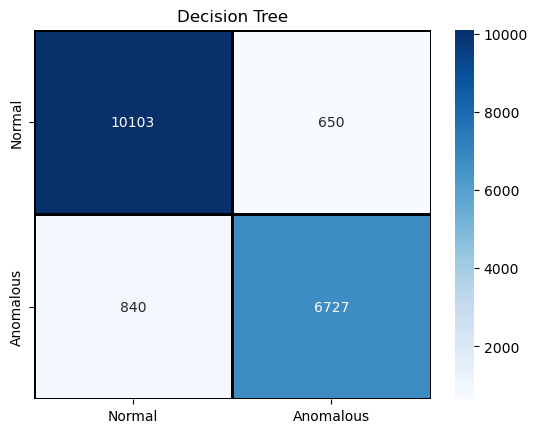

In [49]:
cm = confusion_matrix(y_ts,DT_predictions)
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
plt.title("Decision Tree")
plt.xlabel("Predicted")
plt.ylabel("Actual")
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = label,yticklabels = label)

**Logistic Regression**

In [50]:
LR_model = LogisticRegression(random_state = 42, max_iter = 1000)
print('Computing....')
LR_model.fit(x_tr,y_tr)
print('Done!')

Computing....
Done!


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [51]:
LR_predictions= LR_model.predict(x_ts)
print('MAE', mean_absolute_error(y_ts, LR_predictions))
print("Accuracy", accuracy_score(y_ts, LR_predictions))
print("Precision", precision_score(y_ts, LR_predictions, average='weighted', labels=np.unique(LR_predictions)))
print("Recall", recall_score(y_ts, LR_predictions, average='weighted', labels=np.unique(LR_predictions)))
print("F1", f1_score(y_ts, LR_predictions, average='weighted', labels=np.unique(LR_predictions)))
print("ROC AUC", roc_auc_score(y_ts,LR_predictions, average='weighted', labels=np.unique(LR_predictions)))
error_lr = (LR_predictions != y_ts).mean()
print("Test error: {:.1%}".format(error_lr))

MAE 0.2210698689956332
Accuracy 0.7789301310043668
Precision 0.7804418464189096
Recall 0.7789301310043668
F1 0.7738583158524335
ROC AUC 0.757097742328549
Test error: 22.1%


<Axes: title={'center': 'Logistic Regression'}>

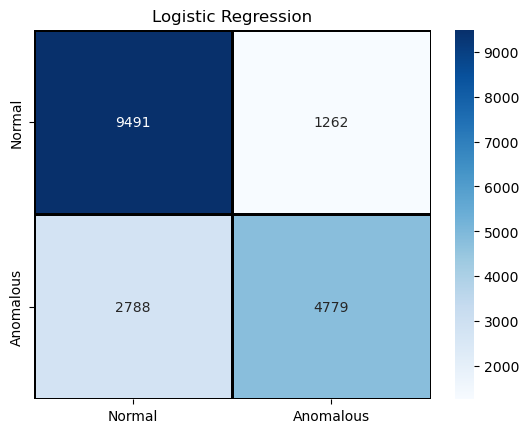

In [52]:
cm = confusion_matrix(y_ts,LR_predictions)
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
plt.title("Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = label,yticklabels = label)

**Support Vector Machine (SVM)**

In [53]:
SVC_model = SVC()
print('Computing....') 
SVC_model.fit(x_tr,y_tr)
print('Done!')

Computing....
Done!


In [54]:
SVC_predictions= SVC_model.predict(x_ts)
print('MAE', mean_absolute_error(y_ts, SVC_predictions))
print("Accuracy", accuracy_score(y_ts, SVC_predictions))
print("Precision", precision_score(y_ts, SVC_predictions, average='weighted', labels=np.unique(SVC_predictions)))
print("Recall", recall_score(y_ts, SVC_predictions, average='weighted', labels=np.unique(SVC_predictions)))
print("F1", f1_score(y_ts, SVC_predictions, average='weighted', labels=np.unique(SVC_predictions)))
print("ROC AUC", roc_auc_score(y_ts,SVC_predictions, average='weighted', labels=np.unique(SVC_predictions)))
error_svc = (SVC_predictions != y_ts).mean()
print("Test error: {:.1%}".format(error_svc))

MAE 0.2865174672489083
Accuracy 0.7134825327510917
Precision 0.7113913094094383
Recall 0.7134825327510917
F1 0.7119658770270874
ROC AUC 0.6999754178398815
Test error: 28.7%


<Axes: title={'center': 'SVC'}>

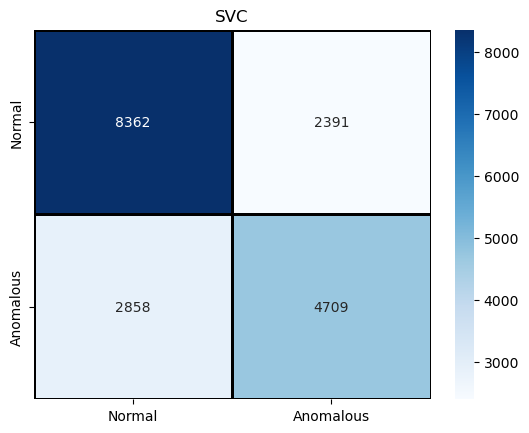

In [55]:
cm = confusion_matrix(y_ts,SVC_predictions)
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
plt.title("SVC")
plt.xlabel("Predicted")
plt.ylabel("Actual")
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = label,yticklabels = label)

**Naïves Bayes**

In [56]:
NB_model = GaussianNB ()
print('Computing....')
NB_model.fit(x_tr,y_tr)
print('Done!')

Computing....
Done!


In [57]:
NB_predictions= NB_model.predict(x_ts)
print('MAE', mean_absolute_error(y_ts, NB_predictions))
print("Accuracy", accuracy_score(y_ts, NB_predictions))
print("Precision", precision_score(y_ts, NB_predictions, average='weighted', labels=np.unique(NB_predictions)))
print("Recall", recall_score(y_ts, NB_predictions, average='weighted', labels=np.unique(NB_predictions)))
print("F1", f1_score(y_ts, NB_predictions, average='weighted', labels=np.unique(NB_predictions)))
print("ROC AUC", roc_auc_score(y_ts,NB_predictions, average='weighted', labels=np.unique(NB_predictions)))
error_nb = (NB_predictions != y_ts).mean()
print("Test error: {:.1%}".format(error_nb))

MAE 0.3015829694323144
Accuracy 0.6984170305676856
Precision 0.7051241268906004
Recall 0.6984170305676856
F1 0.678601361031511
ROC AUC 0.6586953443131436
Test error: 30.2%


<Axes: title={'center': 'NB'}>

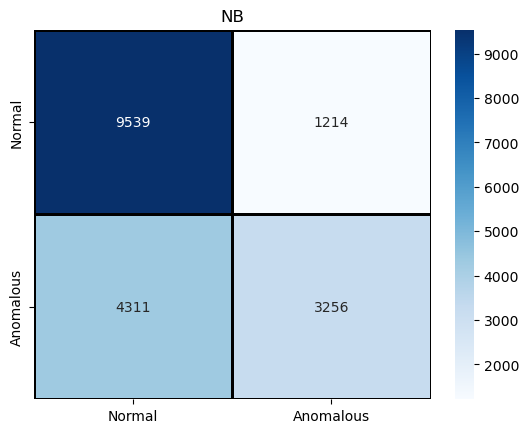

In [58]:
cm = confusion_matrix(y_ts,NB_predictions)
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
plt.title("NB")
plt.xlabel("Predicted")
plt.ylabel("Actual")
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = label,yticklabels = label)

**Recurrent Neural Network(RNN)** 

In [59]:
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
RNN_model = Sequential()
RNN_model.add(SimpleRNN(50, input_shape=(x_tr.shape[1], 1), activation='relu'))
RNN_model.add(Dense(1, activation='sigmoid'))

# Compile the model
RNN_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
RNN_model.fit(x_tr, y_tr, epochs=10, batch_size=32, validation_data=(x_ts, y_ts))

# Evaluate the model's performance on the test set
accuracy = RNN_model.evaluate(x_ts, y_ts)[1]

print(f'Accuracy: {accuracy}')

Epoch 1/10
1336/1336 [==============================] - 11s 7ms/step - loss: 0.5410 - accuracy: 0.7104 - val_loss: 0.4460 - val_accuracy: 0.7656
Epoch 2/10
1336/1336 [==============================] - 10s 7ms/step - loss: 0.4438 - accuracy: 0.7547 - val_loss: 0.4734 - val_accuracy: 0.7484
Epoch 3/10
1336/1336 [==============================] - 10s 7ms/step - loss: 0.4162 - accuracy: 0.7733 - val_loss: 0.4170 - val_accuracy: 0.7569
Epoch 4/10
1336/1336 [==============================] - 9s 7ms/step - loss: 0.4090 - accuracy: 0.7806 - val_loss: 0.3889 - val_accuracy: 0.8014
Epoch 5/10
1336/1336 [==============================] - 9s 7ms/step - loss: 0.3838 - accuracy: 0.7965 - val_loss: 0.3742 - val_accuracy: 0.8026
Epoch 6/10
1336/1336 [==============================] - 10s 7ms/step - loss: 0.3991 - accuracy: 0.7874 - val_loss: 0.3954 - val_accuracy: 0.7885
Epoch 7/10
1336/1336 [==============================] - 9s 7ms/step - loss: 0.3860 - accuracy: 0.7924 - val_loss: 0.3606 - val_accur

**Artificial Neural Network(ANN)**

In [60]:
ANN_model = Sequential()
ANN_model.add(Dense(64, input_dim=x_tr.shape[1], activation='relu'))
ANN_model.add(Dense(32, activation='relu'))
ANN_model.add(Dense(1, activation='sigmoid'))

# Compile the model
ANN_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
ANN_model.fit(x_tr, y_tr, epochs=10, batch_size=32, validation_data=(x_ts, y_ts))

# Evaluate the model's performance on the test set
accuracy = ANN_model.evaluate(x_ts, y_ts)[1]

print(f'Accuracy: {accuracy}')

Epoch 1/10
1336/1336 [==============================] - 5s 3ms/step - loss: 0.5927 - accuracy: 0.7377 - val_loss: 0.4803 - val_accuracy: 0.7764
Epoch 2/10
1336/1336 [==============================] - 4s 3ms/step - loss: 0.4779 - accuracy: 0.7751 - val_loss: 0.4934 - val_accuracy: 0.7718
Epoch 3/10
1336/1336 [==============================] - 4s 3ms/step - loss: 0.4445 - accuracy: 0.7842 - val_loss: 0.4561 - val_accuracy: 0.7908
Epoch 4/10
1336/1336 [==============================] - 4s 3ms/step - loss: 0.4231 - accuracy: 0.7917 - val_loss: 0.4051 - val_accuracy: 0.7949
Epoch 5/10
1336/1336 [==============================] - 4s 3ms/step - loss: 0.3917 - accuracy: 0.8028 - val_loss: 0.4153 - val_accuracy: 0.8010
Epoch 6/10
1336/1336 [==============================] - 4s 3ms/step - loss: 0.3811 - accuracy: 0.8075 - val_loss: 0.3569 - val_accuracy: 0.8275
Epoch 7/10
1336/1336 [==============================] - 4s 3ms/step - loss: 0.3570 - accuracy: 0.8174 - val_loss: 0.3655 - val_accuracy:

**Convolutional Neural Network(CNN)**

In [61]:
from tensorflow.keras import layers, models
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
# from sklearn.feature_extraction.text import Tokenizer

CNN_model = models.Sequential()
CNN_model.add(layers.Conv1D(32, 3, activation='relu', input_shape=(x_tr.shape[1], 1)))
CNN_model.add(layers.MaxPooling1D(2))
CNN_model.add(layers.Conv1D(64, 3, activation='relu'))
CNN_model.add(layers.MaxPooling1D(2))
CNN_model.add(layers.Flatten())
CNN_model.add(layers.Dense(64, activation='relu'))
CNN_model.add(layers.Dense(len(np.unique(y)), activation='softmax'))  # Adjust the output layer based on the number of classes

# Compile the model
CNN_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
CNN_model.fit(x_tr, y_tr, epochs=10, validation_data=(x_ts, y_ts))

# Evaluate the model
test_loss, test_acc = CNN_model.evaluate(x_ts, y_ts, verbose=2)
print(f'\nTest accuracy: {test_acc}')

Epoch 1/10
1336/1336 [==============================] - 8s 5ms/step - loss: 0.5492 - accuracy: 0.7224 - val_loss: 0.4559 - val_accuracy: 0.7647
Epoch 2/10
1336/1336 [==============================] - 6s 5ms/step - loss: 0.4220 - accuracy: 0.7895 - val_loss: 0.3891 - val_accuracy: 0.7950
Epoch 3/10
1336/1336 [==============================] - 6s 5ms/step - loss: 0.3696 - accuracy: 0.8134 - val_loss: 0.3476 - val_accuracy: 0.8144
Epoch 4/10
1336/1336 [==============================] - 6s 5ms/step - loss: 0.3492 - accuracy: 0.8216 - val_loss: 0.3407 - val_accuracy: 0.8233
Epoch 5/10
1336/1336 [==============================] - 6s 5ms/step - loss: 0.3315 - accuracy: 0.8322 - val_loss: 0.3330 - val_accuracy: 0.8311
Epoch 6/10
1336/1336 [==============================] - 6s 4ms/step - loss: 0.3188 - accuracy: 0.8363 - val_loss: 0.3137 - val_accuracy: 0.8339
Epoch 7/10
1336/1336 [==============================] - 6s 5ms/step - loss: 0.3079 - accuracy: 0.8394 - val_loss: 0.3254 - val_accuracy:

**RANKING THE TRAINED MODELS ON THE MAE VALUE**

In [62]:
from sklearn.metrics import accuracy_score

model_preds = [RT_predictions, knn_predictions, DT_predictions, LR_predictions, SVC_predictions, NB_predictions]
model_names = ['Random Forest', 'K-Nearest Neighbors', 'Decision Tree', 'Logistic Regression', 'SVC', 'NB']

# Function for comparing different models
def score_model(model_preds, y_ts):
    return accuracy_score(y_ts, model_preds)

# Calculate Accuracy for each model
acc_score = []
for i in range(len(model_names)):
    acc = score_model(model_preds[i], y_ts)
    acc_score.append((model_names[i], acc))

acc_scores_sorted = sorted(acc_score, key=lambda x: x[1], reverse= True)
target_range = y_ts.max() - y_ts.min()

# Print ranked model names, MAE scores, and error percentages
# for i, (model_name, acc) in enumerate(acc_scores_sorted):
#     error_percent = (mae / target_range) * 100  # Calculate error percentage
#     print("Rank %d: %s - Accuracy: %.4f - : %.2f%%" % (i+1, model_name, acc, error_percent))
print("Done!")

Done!


In [63]:
model_preds = [RT_predictions, knn_predictions, DT_predictions, LR_predictions, SVC_predictions, NB_predictions]
model_names = ['Random Forest', 'K-Nearest Neighbors', 'Decision Tree', 'Logistic Regression','SVC', 'NB']

# Calculate Accuracy for each model
acc_score = []
for i in range(len(model_names)):
    acc = score_model(model_preds[i], y_ts)
    acc_score.append((model_names[i], acc))

acc_scores_sorted = sorted(acc_score, key=lambda x: x[1], reverse= True)
target_range = y_ts.max() - y_ts.min()

# Print ranked model names, Accuracy scores, and Accuracy percentages
for i, (model_name, acc) in enumerate(acc_scores_sorted):
    error_percent = (acc / target_range) * 100  # Calculate error percentage
    print("Rank %d: %s - ACC: %.4f - Accuracy: %.2f%%" % (i+1, model_name, acc, error_percent))

Rank 1: Random Forest - ACC: 0.9263 - Accuracy: 92.63%
Rank 2: Decision Tree - ACC: 0.9187 - Accuracy: 91.87%
Rank 3: K-Nearest Neighbors - ACC: 0.9153 - Accuracy: 91.53%
Rank 4: Logistic Regression - ACC: 0.7789 - Accuracy: 77.89%
Rank 5: SVC - ACC: 0.7135 - Accuracy: 71.35%
Rank 6: NB - ACC: 0.6984 - Accuracy: 69.84%
